# Word2vec bias #

In [1]:
import gensim

# Load pretrained model (since intermediate data is not included, the model cannot be refined with additional data)
# I used this version: http://academictorrents.com/details/2aa0d0c6aff92f08719e409db04ecee4721cf21f
# Note: loading the embeddings takes around 10 minutes, and I recommend you to have at least 8 GB of ram. 
filepath = 'GoogleNews-vectors-negative300.bin.gz'
model = gensim.models.KeyedVectors.load_word2vec_format(filepath, binary=True)

C:\Users\emmag\Anaconda3\lib\site-packages\gensim\utils.py:1209: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")


First, let us look at the standard examples:

In [76]:
print("Most similar to computer_programmer - he + she: \n",model.most_similar(positive = ['computer_programmer', 'she'], negative = ['he'], topn = 5))
print("Most similar to beautician - she + he: \n", model.most_similar(positive = ['beautician', 'he'], negative = ['she'], topn = 5))


C:\Users\emmag\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Most similar to computer_programmer - he + she: 
 [('homemaker', 0.5700257420539856), ('housewife', 0.5342153906822205), ('businesswoman', 0.5196776986122131), ('saleswoman', 0.5168929696083069), ('graphic_designer', 0.5157608985900879)]
Most similar to beautician - she + he: 
 [('barber', 0.6375421285629272), ('handyman', 0.5406479239463806), ('carpenter', 0.5381854176521301), ('mechanic', 0.526857852935791), ('electrician', 0.5152750015258789)]


However, other examples seem to be less shocking:

In [77]:
print("Most similar to programmer - he + she: \n", model.most_similar(positive = ['programmer', 'she'], negative = ['he'], topn = 5))


C:\Users\emmag\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


Most similar to programmer - he + she: 
 [('programmers', 0.5277909636497498), ('coder', 0.5032480359077454), ('Programmer', 0.5006574392318726), ('graphic_designer', 0.48125556111335754), ('librarian', 0.4702720642089844)]


Next, we wonder if these analogies hold both ways. If _computer programmer - he + she = homemaker_, does the reverse also hold? What is the result of _homemaker - she + he_ ? 

In [7]:
def analogy_convergence(biassed_word, fromword = 'he', toword = 'she', N = 10):
    firstfrom = fromword
    firstto = toword
    biassed_from = biassed_word
    biassed_to = ""
    for i in range(N):
        analogy = model.most_similar(positive = [biassed_from, toword], negative = [fromword], topn = 1)[0][0]
        print(biassed_from, " - ", fromword, " + ", toword, " = ", analogy)
        if analogy == biassed_to:
            break
        else:
            biassed_to = biassed_from
            biassed_from = analogy
            if i%2 == 0:
                fromword = firstto
                toword = firstfrom
            else:
                fromword = firstfrom
                toword = firstto
    if i == N:
        print("Convergence not reached within ", N, " steps")
        

In [8]:
analogy_convergence('computer_programmer', 'he', 'she')

C:\Users\emmag\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


computer_programmer  -  he  +  she  =  homemaker
homemaker  -  she  +  he  =  carpenter
carpenter  -  he  +  she  =  seamstress
seamstress  -  she  +  he  =  carpenter


In [10]:
analogy_convergence('pizzas', 'he', 'she')

C:\Users\emmag\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


pizzas  -  he  +  she  =  cupcakes
cupcakes  -  she  +  he  =  waffles
waffles  -  he  +  she  =  cupcakes


In [11]:
analogy_convergence('pizza', 'he', 'she')

C:\Users\emmag\Anaconda3\lib\site-packages\gensim\matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int32 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


pizza  -  he  +  she  =  Domino_pizza
Domino_pizza  -  she  +  he  =  pizza


We know about the analogies, but what are the actual similarities between the words?

In [14]:
def word_sim(word1, word2):
    return round(1-spatial.distance.cosine(model[word1], model[word2]),2)

In [84]:
from scipy import spatial
print("Distance between 'he' and 'computer_programmer':", word_sim('he', 'computer_programmer'))
print("Distance between 'she' and 'computer_programmer':",word_sim('she', 'computer_programmer'))
print("Distance between 'he' and 'homemaker':", word_sim('he', 'homemaker'))
print("Distance between 'she' and 'homemaker':",word_sim('she', 'homemaker'))
print("Distance between 'he' and 'she':", word_sim('he', 'she'))

Distance between 'he' and 'computer_programmer': 0.18
Distance between 'she' and 'computer_programmer': 0.19
Distance between 'he' and 'homemaker': 0.13
Distance between 'she' and 'homemaker': 0.4
Distance between 'he' and 'she': 0.61


Note that 'she' is closer to 'computer_programmer' than 'he' is!

In [17]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
import umap
import matplotlib.pyplot as plt

def words_pca(word_list, transform = 'pca'):
    # Looking up the vectors per word
    bias_vectors = [model[word] for word in word_list]
    # scaling the wordvectors
    bias_vectors = StandardScaler().fit_transform(bias_vectors)
    # applying PCA with 2 components
    if transform == 'pca':
        pca = PCA(n_components=2)
        bias_pca = pca.fit_transform(bias_vectors)
    elif transform == 'tsne':
        bias_pca = TSNE(n_components=2).fit_transform(bias_vectors)
    else:
        bias_pca = umap.UMAP().fit_transform(bias_vectors)
    return bias_pca
    

In the Bolukbasi et al. paper, they list the following words as most biased in gender. You can optionally add a list of super gendered words by uncommenting  the line after 'optional, add gendered words'. This is to push 'gender' as the principal component. 

In [19]:
super_gendered = ['king', 'queen', 'brother', 'sister', 'mother', 'father',
                  'she', 'woman', 'he', 'man', 'grandpa', 'grandma', 'boy', 'girl',
                 'her', 'his', 'daughter', 'son', 'Mary', 'John']

In [64]:
# setting the plotsize
plt.rcParams['figure.figsize'] = [15, 15]

First to see how gendered word embeddings are, we make plot the vectors. Since 300-dimensional plots are not very intuitive for humans, we need to reduce the dimensionality to two dimensions. There are multiple ways to do this, such as PCA, TSNE and UMAP. First we look at the words which the authors describe as being biassed.

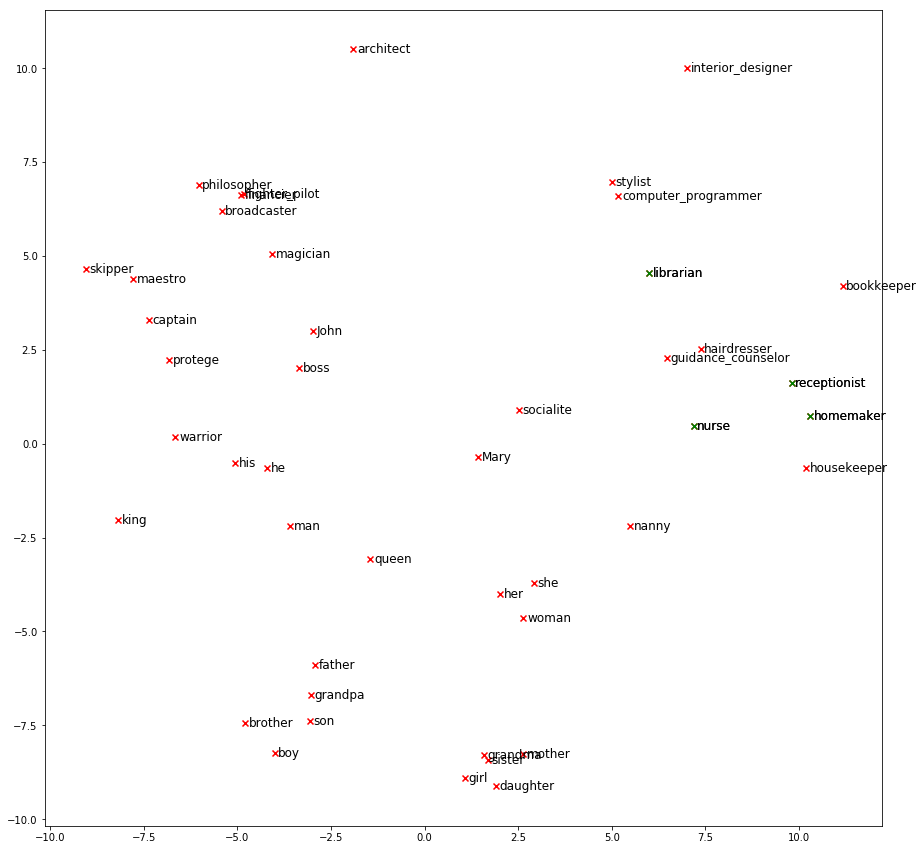

In [92]:
# list of biased words, without the genderwords:
bias_words = ['homemaker', 'nurse', 'receptionist', 'librarian', 
              'socialite', 'hairdresser', 'nanny', 'bookkeeper', 'stylist','housekeeper', 
              'interior_designer', 'guidance_counselor',
              'maestro', 'skipper', 'protege', 'philosopher', 'captain', 
              'architect','financier', 'warrior', 'broadcaster',
              'magician', 'fighter_pilot', 'boss', 'computer_programmer']

# Optional: add gendered words:
bias_words = bias_words + super_gendered

# Calculating the bias
# Options for dimensionality reduction: pca, tsne and umap
bias_pca = words_pca(bias_words, transform = 'pca')


# Plotting the PCA with words
plt.figure


some_words = ['homemaker', 'nurse', 'receptionist', 'librarian']
for i,word in enumerate(bias_words):
    x = bias_pca[i,0]
    y = bias_pca[i,1]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+0.1, y-0.1, word, fontsize=12)
for i,word in enumerate(some_words):
    x = bias_pca[i,0]
    y = bias_pca[i,1]
    plt.scatter(x, y, marker='x', color='green')
    plt.text(x+0.1, y-0.1, word, fontsize=12)
plt.show()

Now we also look at a list of professions, took from the following website: https://www.vocabulary.cl/Basic/Professions.htm

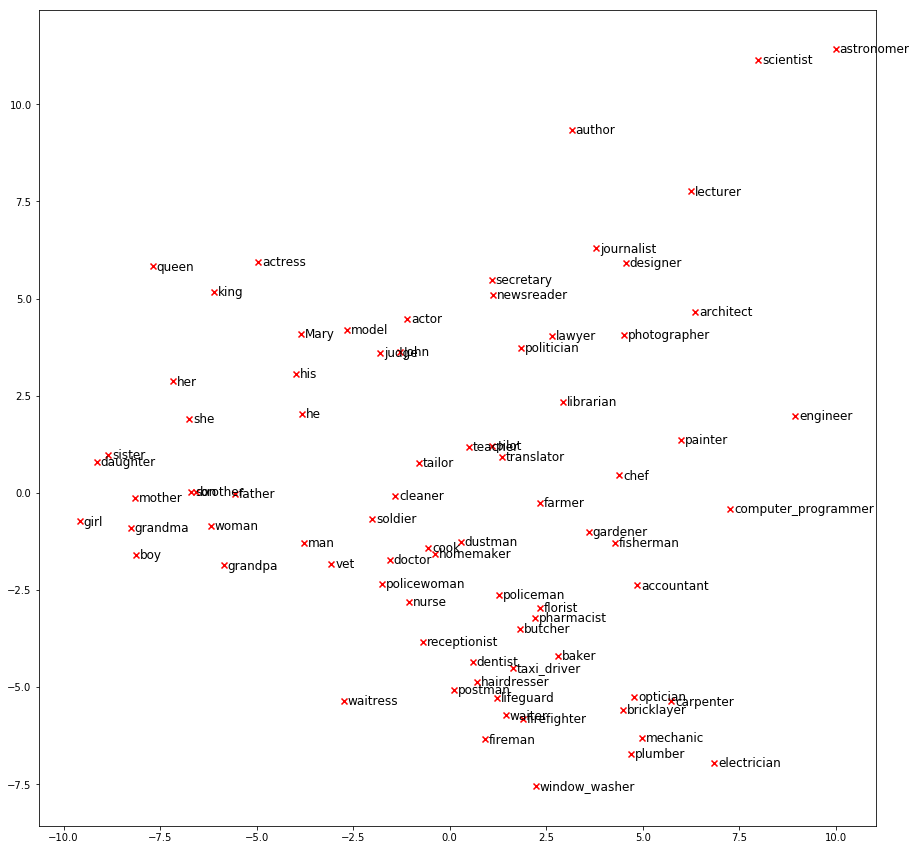

In [82]:
# List of random professions I got online, with some extra gender words
bias_words = ['accountant', 'actor', 'actress', 'architect', 'astronomer', 'author', 'baker', 'bricklayer', 
              'butcher', 'carpenter', 'chef', 'cook', 'cleaner', 'dentist', 'designer',
             'doctor', 'dustman', 'electrician', 'engineer',
             'farmer', 'fireman', 'firefighter', 'fisherman', 'florist', 'gardener', 'hairdresser',
             'journalist', 'judge', 'lawyer', 'lecturer', 'librarian', 'lifeguard', 'mechanic',
             'model', 'newsreader', 'nurse', 'optician', 'painter', 'pharmacist', 'photographer',
             'pilot', 'plumber', 'politician', 'policeman', 'policewoman', 'postman', 
             'receptionist', 'scientist', 'secretary', 'soldier', 'tailor', 'taxi_driver',
             'teacher', 'translator', 'vet', 'waiter', 'waitress',
             'window_washer', 'computer_programmer', 'homemaker']

# Optional: add gendered words:
bias_words = bias_words + super_gendered

# Calculating the bias
bias_pca = words_pca(bias_words, transform = 'pca')

# Plotting the PCA with words

for i,word in enumerate(bias_words):
    x = bias_pca[i,0]
    y = bias_pca[i,1]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+0.1, y-0.1, word, fontsize=12)
plt.show()

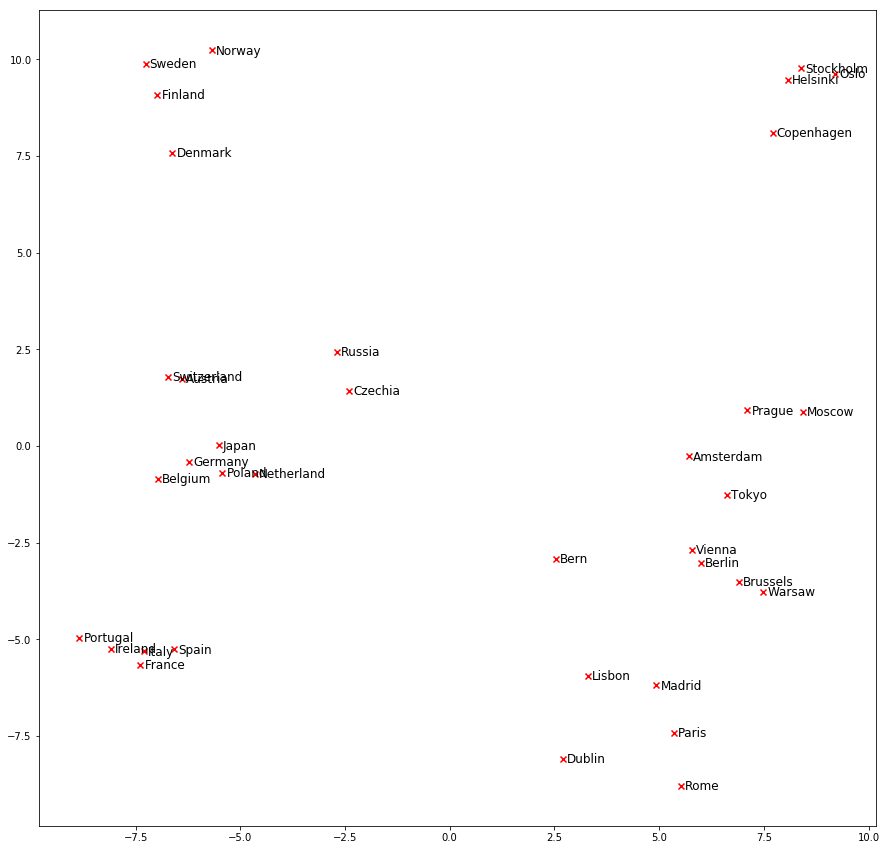

In [75]:
# Just wondering how countries behave
bias_words = ['Austria', 'Vienna', 'Belgium', 'Brussels', 'Czechia', 'Prague', 'Denmark', 'Copenhagen', 'Finland', 'Helsinki',
 'France', 'Paris', 'Germany', 'Berlin', 'Ireland', 'Dublin', 'Italy', 'Rome', 'Netherland', 'Amsterdam', 'Norway',
 'Oslo', 'Poland', 'Warsaw', 'Portugal', 'Lisbon', 'Russia', 'Moscow', 'Spain', 'Madrid', 'Sweden', 'Stockholm',
 'Switzerland', 'Bern']
# Optional: add gendered words:
#bias_words = bias_words + super_gendered

# Calculating the bias
bias_pca = words_pca(bias_words, transform = 'pca')

# Plotting the PCA with words

for i,word in enumerate(bias_words):
    x = bias_pca[i,0]
    y = bias_pca[i,1]
    plt.scatter(x, y, marker='x', color='red')
    plt.text(x+0.1, y-0.1, word, fontsize=12)
plt.show()



In [48]:
# In case you want to add a new list of words
def check_in_word2vec(wordlist):
    checked_list = []
    for word in wordlist:
        if word in model.vocab:
            checked_list.append(word)
    return checked_list